In [3]:
import numpy as np
import pandas as pd
import matplotlib as mpl
from pyspark.sql.functions import *
from matplotlib import pyplot as plt
from pyspark.sql.types import TimestampType
%matplotlib inline

from pyspark import SparkContext
spark = SparkSession \
 .builder \
 .appName("Final_Project_Task3") \
 .config("spark.some.config.option", "some-value") \
 .getOrCreate()

In [4]:
# Need to specify the delimeter
file = "erm2-nwe9.tsv"
data_2010_to_present = spark.read.format('csv').options(header='true', inferschema='true', sep = '\t').load(file)

In [5]:
data_set = data_2010_to_present.select('Unique Key','Created Date','Closed Date','Complaint Type','Descriptor','Borough')

In [6]:
from pyspark.sql.functions import col

data_subset = data_set.select(col("Unique Key").alias("Unique_Key"), 
	col("Created Date").alias("Created_Date"),
	col("Closed Date").alias("Closed_Date"),
	col("Complaint Type").alias("Complaint_Type"),
	col("Descriptor").alias("Descriptor"),
	col("Borough").alias("Borough")
	)

data_subset.printSchema()

root
 |-- Unique_Key: integer (nullable = true)
 |-- Created_Date: string (nullable = true)
 |-- Closed_Date: string (nullable = true)
 |-- Complaint_Type: string (nullable = true)
 |-- Descriptor: string (nullable = true)
 |-- Borough: string (nullable = true)



In [7]:
from pyspark.sql.functions import from_unixtime, unix_timestamp, col

data_subset = data_subset.withColumn('Created_Date', from_unixtime(unix_timestamp(col(('Created_Date')), "MM/dd/yyyy hh:mm:ss aa"), "MM/dd/yyyy HH:mm:ss"))
data_subset = data_subset.withColumn('Closed_Date', from_unixtime(unix_timestamp(col(('Closed_Date')), "MM/dd/yyyy hh:mm:ss aa"), "MM/dd/yyyy HH:mm:ss"))

data_subset = data_subset.withColumn('Created_Date', unix_timestamp('Created_Date', "MM/dd/yyyy HH:mm:ss").cast(TimestampType()).alias("Created_Date"))
data_subset = data_subset.withColumn('Closed_Date', unix_timestamp('Closed_Date', "MM/dd/yyyy HH:mm:ss").cast(TimestampType()).alias("Closed_Date"))

In [8]:
data_subset.printSchema()
data_subset.show()

root
 |-- Unique_Key: integer (nullable = true)
 |-- Created_Date: timestamp (nullable = true)
 |-- Closed_Date: timestamp (nullable = true)
 |-- Complaint_Type: string (nullable = true)
 |-- Descriptor: string (nullable = true)
 |-- Borough: string (nullable = true)

+----------+-------------------+-------------------+--------------------+------------+-----------+
|Unique_Key|       Created_Date|        Closed_Date|      Complaint_Type|  Descriptor|    Borough|
+----------+-------------------+-------------------+--------------------+------------+-----------+
|  16386856|2010-04-06 00:00:00|2010-04-07 00:00:00|            PLUMBING|     BATHTUB|Unspecified|
|  16386857|2010-04-06 00:00:00|2010-04-13 00:00:00|            PLUMBING|     BATHTUB|Unspecified|
|  16386858|2010-04-06 00:00:00|2010-04-24 00:00:00|     PAINT - PLASTER|       WALLS|Unspecified|
|  16386859|2010-04-06 00:00:00|2010-04-13 00:00:00|     PAINT - PLASTER|       WALLS|Unspecified|
|  16386860|2010-04-06 00:00:00|2010-0

In [9]:
# Getting Rid of the rows with Unspecified Boro & Created Date is not Null

data_subset = data_subset.filter(data_subset.Borough != 'Unspecified')
data_subset = data_subset.filter(col("Created_Date").isNotNull())

data_subset.createOrReplaceTempView("data_subset_sql")


In [20]:
# Setting up top 3 for each Boro

bx_count = spark.sql("select Borough, Complaint_Type, count(*) as count \
from data_subset_sql \
group by Borough, Complaint_Type \
having Borough = 'BRONX' \
order by Borough, count desc limit 3")

pdf_bx = bx_count.toPandas()

############################################################

si_count = spark.sql("select Borough, Complaint_Type, count(*) as count \
from data_subset_sql \
group by Borough, Complaint_Type \
having Borough = 'STATEN ISLAND' \
order by Borough, count desc limit 3")

pdf_si = si_count.toPandas()

############################################################

bk_count = spark.sql("select Borough, Complaint_Type, count(*) as count \
from data_subset_sql \
group by Borough, Complaint_Type \
having Borough = 'BROOKLYN' \
order by Borough, count desc limit 3")

pdf_bk = bk_count.toPandas()

############################################################

q_count = spark.sql("select Borough, Complaint_Type, count(*) as count \
from data_subset_sql \
group by Borough, Complaint_Type \
having Borough = 'QUEENS' \
order by Borough, count desc limit 3")

pdf_q = q_count.toPandas()

############################################################

mhtn_count = spark.sql("select Borough, Complaint_Type, count(*) as count \
from data_subset_sql \
group by Borough, Complaint_Type \
having Borough = 'MANHATTAN' \
order by Borough, count desc limit 3")

pdf_mhtn = mhtn_count.toPandas()


In [10]:
# Show top 3 complaint types by boro in DF form

bx_count.show()
si_count.show()
bk_count.show()
q_count.show()
mhtn_count.show()


+-------+-------------------+------+
|Borough|     Complaint_Type| count|
+-------+-------------------+------+
|  BRONX|Noise - Residential|432285|
|  BRONX|     HEAT/HOT WATER|374641|
|  BRONX|            HEATING|195284|
+-------+-------------------+------+

+-------------+--------------------+------+
|      Borough|      Complaint_Type| count|
+-------------+--------------------+------+
|STATEN ISLAND|    Street Condition|119212|
|STATEN ISLAND|Street Light Cond...| 58865|
|STATEN ISLAND|        Water System| 54529|
+-------------+--------------------+------+

+--------+-------------------+------+
| Borough|     Complaint_Type| count|
+--------+-------------------+------+
|BROOKLYN|Noise - Residential|522802|
|BROOKLYN|     HEAT/HOT WATER|352798|
|BROOKLYN|   Blocked Driveway|322728|
+--------+-------------------+------+

+-------+-------------------+------+
|Borough|     Complaint_Type| count|
+-------+-------------------+------+
| QUEENS|   Blocked Driveway|358989|
| QUEENS|Noise -

In [11]:
# Output for total count of complaint type for all boros
# Need to limit output, it clutters graph 

complaint_count = spark.sql("select Complaint_Type , count(*) as count \
from data_subset_sql \
group by Complaint_Type \
order by count desc \
limit 20")

pdf_total = complaint_count.toPandas()

Text(0.5,1,'Complaint Type Count for all of NYC')

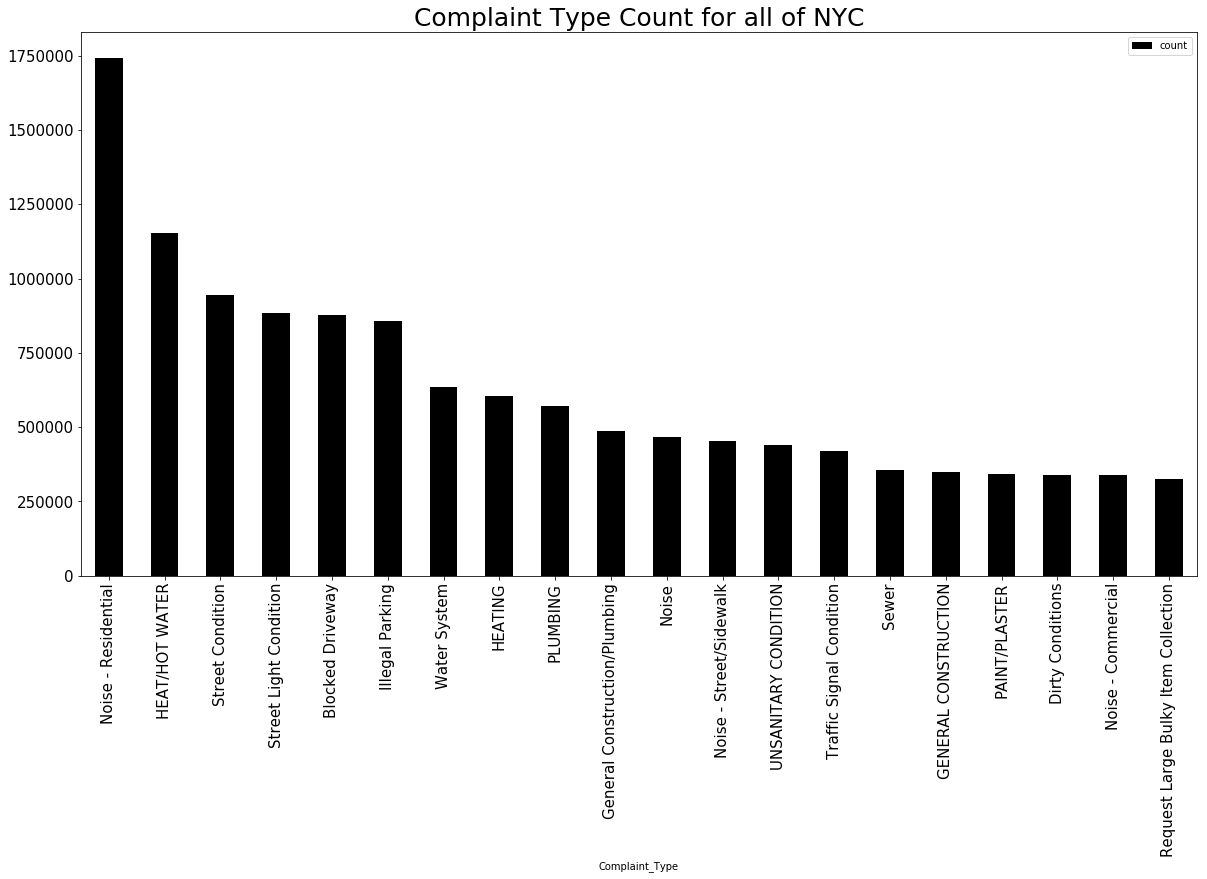

In [14]:
# Total complaint type count plotted

pdf_total.plot(x = 'Complaint_Type', kind = 'bar', figsize=(20,10), facecolor = 'black', fontsize = 15).set_title('Complaint Type Count for all of NYC', fontsize = 25)


Text(0.5,1,'Bronx Top 3 Complaint Types')

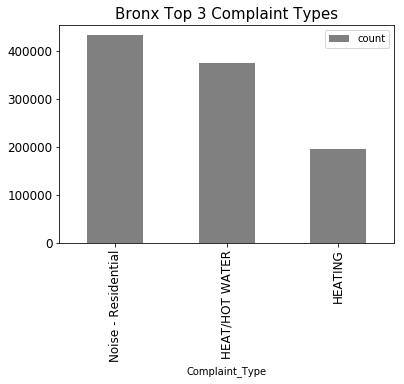

In [21]:
# Top 3 complaints for: Bronx

pdf_bx.plot(x = 'Complaint_Type', kind = 'bar', facecolor = 'grey', fontsize = 12).set_title('Bronx Top 3 Complaint Types', fontsize = 15)


Text(0.5,1,'Staten Island Top 3 Complaint Types')

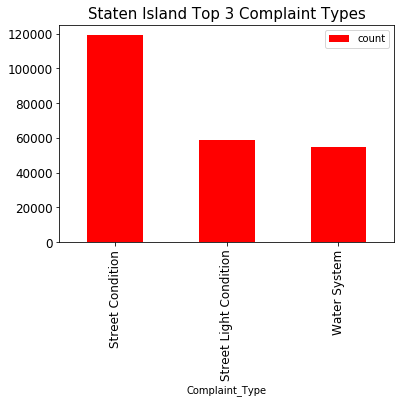

In [17]:
# Top 3 complaints for: Staten Island


pdf_si.plot(x = 'Complaint_Type', kind = 'bar', facecolor = 'red', fontsize = 12).set_title('Staten Island Top 3 Complaint Types',fontsize = 15)


Text(0.5,1,'Brooklyn Top 3 Complaint Types')

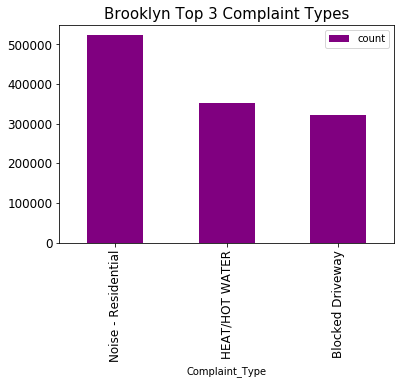

In [18]:
# Top 3 complaints for: Brooklyn


pdf_bk.plot(x = 'Complaint_Type', kind = 'bar', facecolor = 'purple', fontsize = 12).set_title('Brooklyn Top 3 Complaint Types',fontsize = 15)
 

Text(0.5,1,'Queens Top 3 Complaint Types')

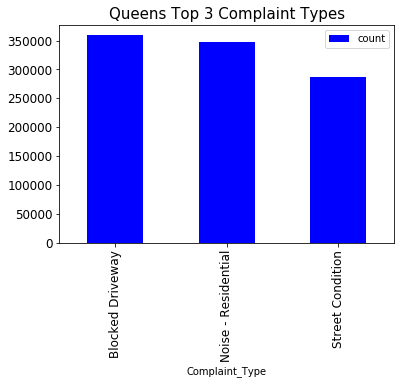

In [19]:
# Top 3 complaints for: Queens


pdf_q.plot(x = 'Complaint_Type', kind = 'bar', facecolor = 'blue', fontsize = 12).set_title('Queens Top 3 Complaint Types',fontsize = 15)


Text(0.5,1,'Manhattan Top 3 Complaint Types')

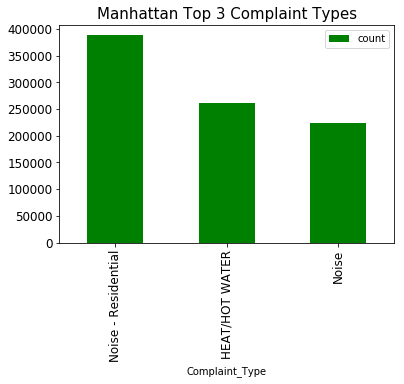

In [20]:
# Top 3 complaints for: Manhattan


pdf_mhtn.plot(x = 'Complaint_Type', kind = 'bar', facecolor = 'green', fontsize = 12).set_title('Manhattan Top 3 Complaint Types',fontsize = 15)


In [10]:

data_subset = data_subset.withColumn('Created_Year', year('Created_Date'))
data_subset = data_subset.withColumn('Created_Month', month('Created_Date'))


In [11]:

time_data = data_subset.select('Borough', 'Complaint_Type', 'Created_Year', 'Created_Month')
time_data.createOrReplaceTempView("time_data_sql")

annual_count = spark.sql("select Created_Year, count(*) as count \
from time_data_sql \
group by Created_Year")

monthly_count = spark.sql("select Created_Month, count(*) as count \
from time_data_sql \
group by Created_Month")


In [23]:

borough_month = spark.sql("select Borough, Created_Month, count(*) as count \
from time_data_sql \
where Created_Month IS NOT NULL \
group by Borough, Created_Month \
order by Created_Month desc")

borough_year = spark.sql("select Borough, Created_Year, count(*) as count \
from time_data_sql \
where Created_Year IS NOT NULL \
group by Borough, Created_Year \
order by Created_Year")


In [24]:
# Complaint Type Count over time: Month

borough_month_pdf = borough_month.toPandas()
borough_month_pdf

borough_month_pivot = borough_month_pdf.pivot(index='Created_Month', columns='Borough', values='count')


In [26]:
# Complaint Type Count over time: Year

borough_year_pdf = borough_year.toPandas()
borough_year_pdf

borough_year_pivot = borough_year_pdf.pivot(index='Created_Year', columns='Borough', values='count')


Text(0.5,1,'Number of Complaints by Month')

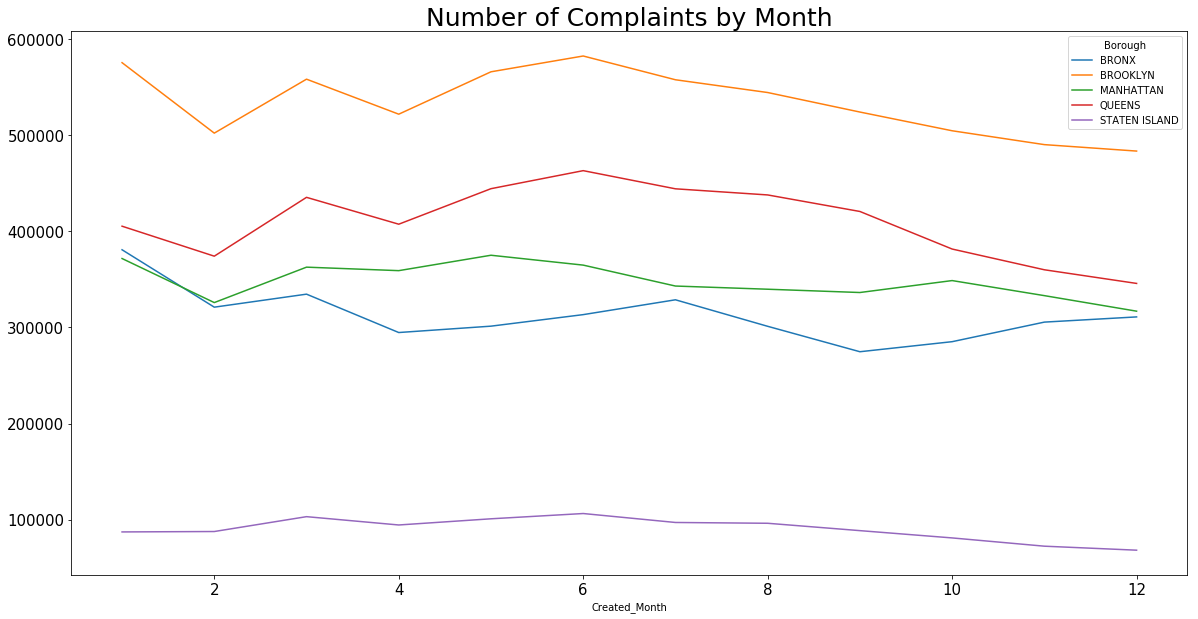

In [27]:
# This is correct out put for complaint type count by month

borough_month_pivot.plot(figsize=(20,10), fontsize = 15).set_title('Number of Complaints by Month', fontsize = 25)

Text(0.5,1,'Number of Complaints by Year')

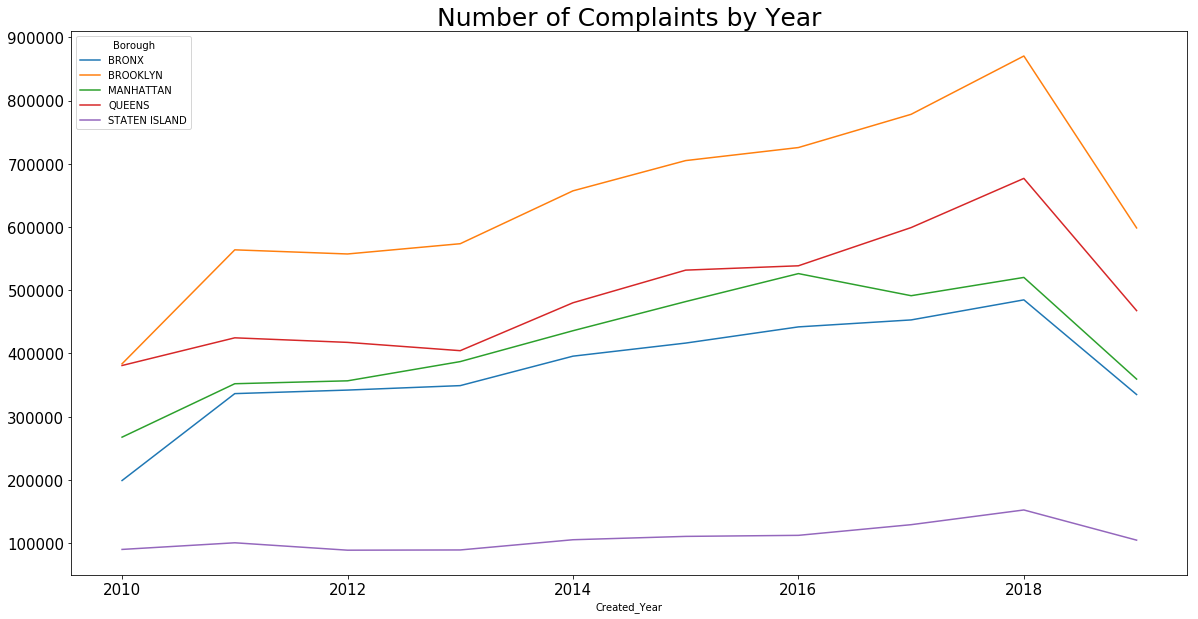

In [28]:
# This is correct out put for complaint type count by year

borough_year_pivot.plot(figsize=(20,10), fontsize = 15).set_title('Number of Complaints by Year', fontsize = 25)

In [29]:
borough_month.createOrReplaceTempView("borough_month_sql")

In [30]:
boro_month_total = spark.sql("select Created_Month, sum(count) \
from borough_month_sql \
group by Created_Month \
order by Created_Month asc")

boro_month_total_pdf = boro_month_total.toPandas()

Text(0.5,1,'Total Complaint Type Count by Month')

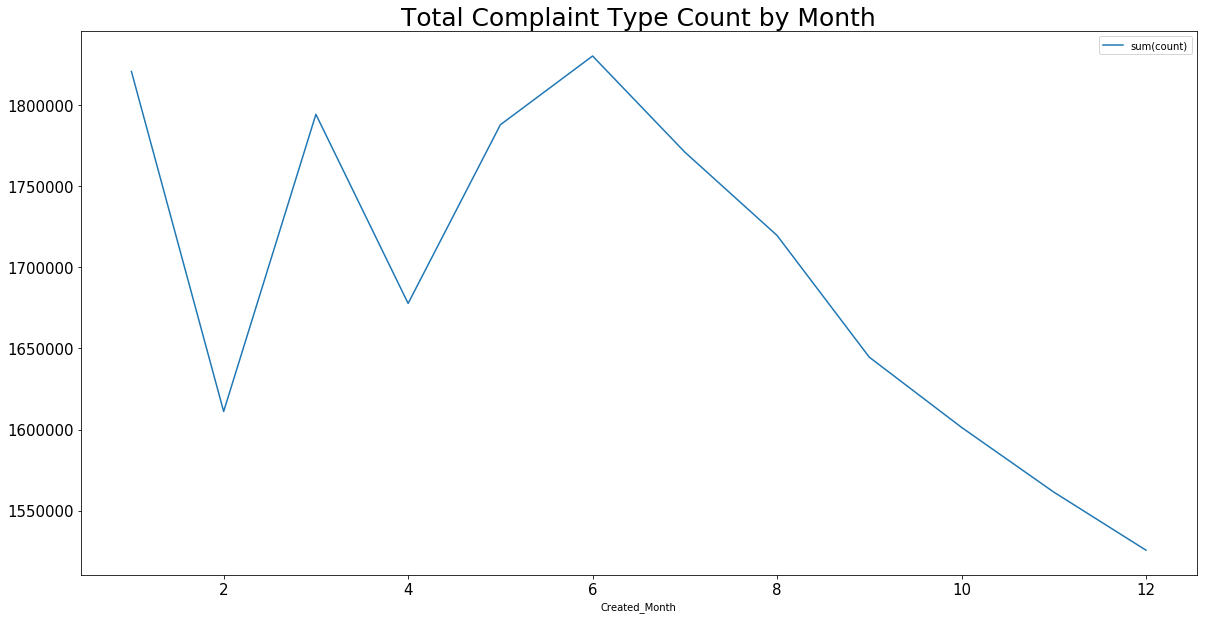

In [31]:
boro_month_total_pdf.plot(x = 'Created_Month',figsize=(20,10), fontsize = 15).set_title('Total Complaint Type Count by Month', fontsize = 25)

In [32]:

borough_year.createOrReplaceTempView("borough_year_sql")

boro_year_total = spark.sql("select Created_Year, sum(count) \
from borough_year_sql \
group by Created_Year \
order by Created_Year asc")

boro_year_total_pdf = boro_year_total.toPandas()


Text(0.5,1,'Total Complaint Type Count by Year')

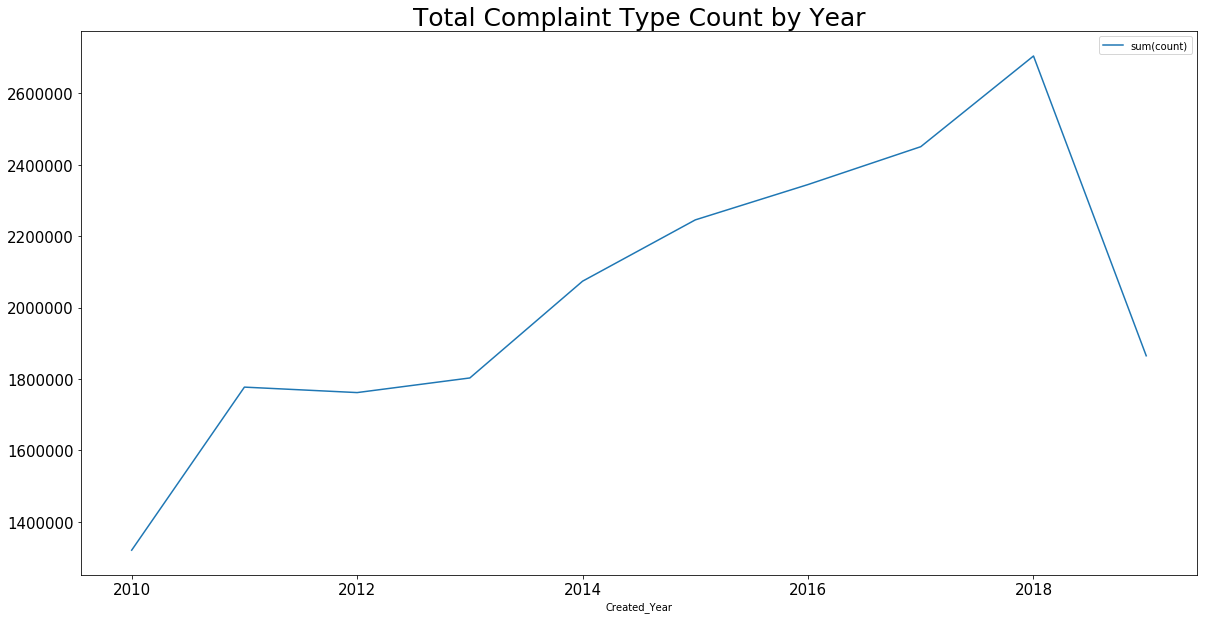

In [34]:
boro_year_total_pdf.plot(x = 'Created_Year', figsize=(20,10), fontsize=15).set_title('Total Complaint Type Count by Year', fontsize = 25)

In [35]:
# Need to figure out the most common complaints by season to explain peaks

spring_complaints = spark.sql("select Created_Month, Complaint_Type, count(*) as count \
from time_data_sql \
where Created_Month between 3 and 5 \
group by Created_Month, Complaint_Type \
order by count desc")

spring_complaints.createOrReplaceTempView("spring_complaints_sql")

spring_complaints_top5 = spark.sql("select Complaint_Type, sum(count) as sum \
from spring_complaints_sql \
group by Complaint_Type \
order by sum desc \
limit 5")

spring_complaints_pdf = spring_complaints_top5.toPandas()

############################################################


summer_complaints = spark.sql("select Created_Month, Complaint_Type, count(*) as count \
from time_data_sql \
where Created_Month between 6 and 8 \
group by Created_Month, Complaint_Type \
order by count desc")

summer_complaints.createOrReplaceTempView("summer_complaints_sql")

summer_complaints_top5 = spark.sql("select Complaint_Type, sum(count) as sum \
from summer_complaints_sql \
group by Complaint_Type \
order by sum desc \
limit 5")

summer_complaints_pdf = summer_complaints_top5.toPandas()

############################################################


fall_complaints = spark.sql("select Created_Month, Complaint_Type, count(*) as count \
from time_data_sql \
where Created_Month between 9 and 11 \
group by Created_Month, Complaint_Type \
order by count desc")

fall_complaints.createOrReplaceTempView("fall_complaints_sql")

fall_complaints_top5 = spark.sql("select Complaint_Type, sum(count) as sum \
from fall_complaints_sql \
group by Complaint_Type \
order by sum desc \
limit 5")

fall_complaints_pdf = fall_complaints_top5.toPandas()

############################################################

winter_complaints = spark.sql("select Created_Month, Complaint_Type, count(*) as count \
from time_data_sql \
where Created_Month = 12 or Created_Month between 1 and 2 \
group by Created_Month, Complaint_Type \
order by count desc")

winter_complaints.createOrReplaceTempView("winter_complaints_sql")

winter_complaints_top5 = spark.sql("select Complaint_Type, sum(count) as sum \
from winter_complaints_sql \
group by Complaint_Type \
order by sum desc \
limit 5")

winter_complaints_pdf = winter_complaints_top5.toPandas()

In [36]:
winter_complaints_pdf

,Complaint_Type,sum
0,HEAT/HOT WATER,568875
1,Noise - Residential,386744
2,HEATING,316582
3,Street Condition,229307
4,Blocked Driveway,220619


In [37]:
spring_complaints_pdf

,Complaint_Type,sum
0,Noise - Residential,463310
1,Street Condition,338234
2,HEAT/HOT WATER,249074
3,Street Light Condition,239909
4,Blocked Driveway,218936


In [38]:
summer_complaints_pdf

,Complaint_Type,sum
0,Noise - Residential,474764
1,Water System,255648
2,Illegal Parking,247702
3,Street Condition,227004
4,Street Light Condition,224058


In [39]:
fall_complaints_pdf

,Complaint_Type,sum
0,Noise - Residential,417280
1,HEAT/HOT WATER,287771
2,Blocked Driveway,219382
3,Street Light Condition,210675
4,Illegal Parking,208967


In [13]:
# I want to have a multi line plot of most common complaint types per season

complaints_monthly = spark.sql("select Complaint_Type, Created_Month, count(*) as count \
from time_data_sql \
where Created_Month IS NOT NULL and Complaint_Type IS NOT NULL \
group by Complaint_Type, Created_Month \
having Complaint_Type in ('Noise - Residential', 'HEAT/HOT WATER', 'HEATING','Street Condition','Street Light Condition',\
'Blocked Driveway','Water System','Illegal Parking')\
order by Created_Month")

complaints_monthly_pdf = complaints_monthly.toPandas()
complaints_monthly_pdf_pivot = complaints_monthly_pdf.pivot(index='Created_Month', columns='Complaint_Type', values='count')

Text(0.5,1,'Complaints by Month')

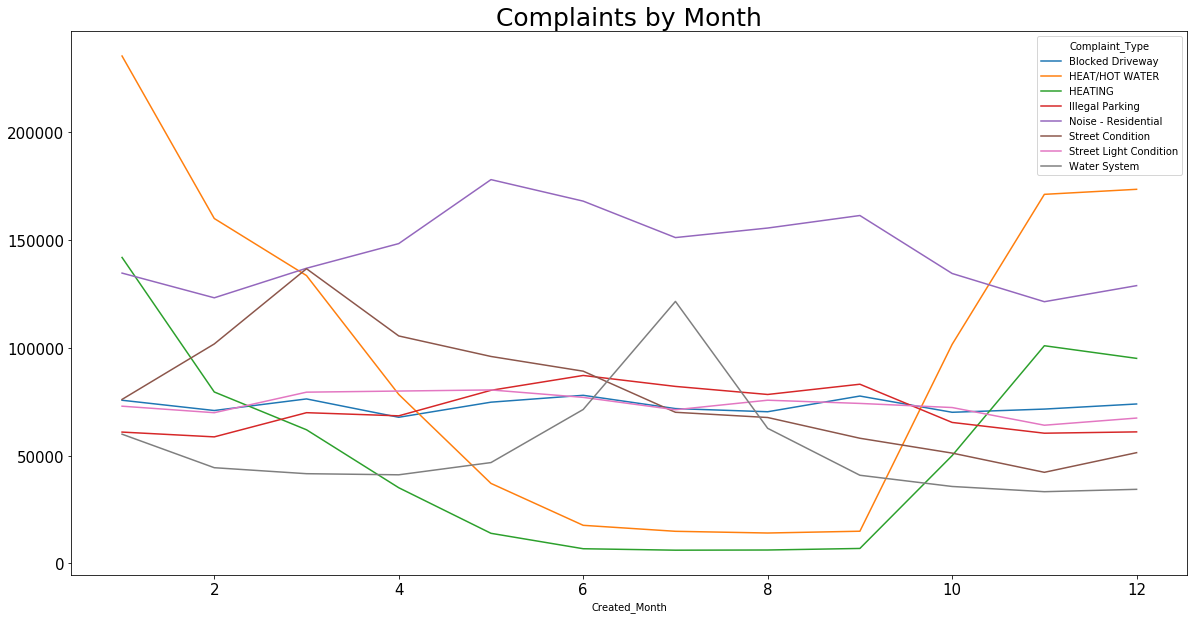

In [14]:

complaints_monthly_pdf_pivot.plot(figsize=(20,10), fontsize=15).set_title('Complaints by Month', fontsize = 25)


In [ ]:
# Because Queens and Brooklyn have the largest number of complaints,
# we want to compare the graph above with those two boroughs

In [15]:
complaints_monthly_bk = spark.sql("select Complaint_Type, Created_Month, count(*) as count \
from time_data_sql \
where Created_Month IS NOT NULL and Complaint_Type IS NOT NULL and Borough = 'BROOKLYN' \
group by Complaint_Type, Created_Month \
having Complaint_Type in ('Noise - Residential', 'HEAT/HOT WATER', 'HEATING','Street Condition','Street Light Condition',\
'Blocked Driveway','Water System','Illegal Parking')\
order by Created_Month")

complaints_monthly_bk_pdf = complaints_monthly_bk.toPandas()
complaints_monthly_pdf_bk_pivot = complaints_monthly_bk_pdf.pivot(index='Created_Month', columns='Complaint_Type', values='count')

Text(0.5,1,'BK Complaints by Month')

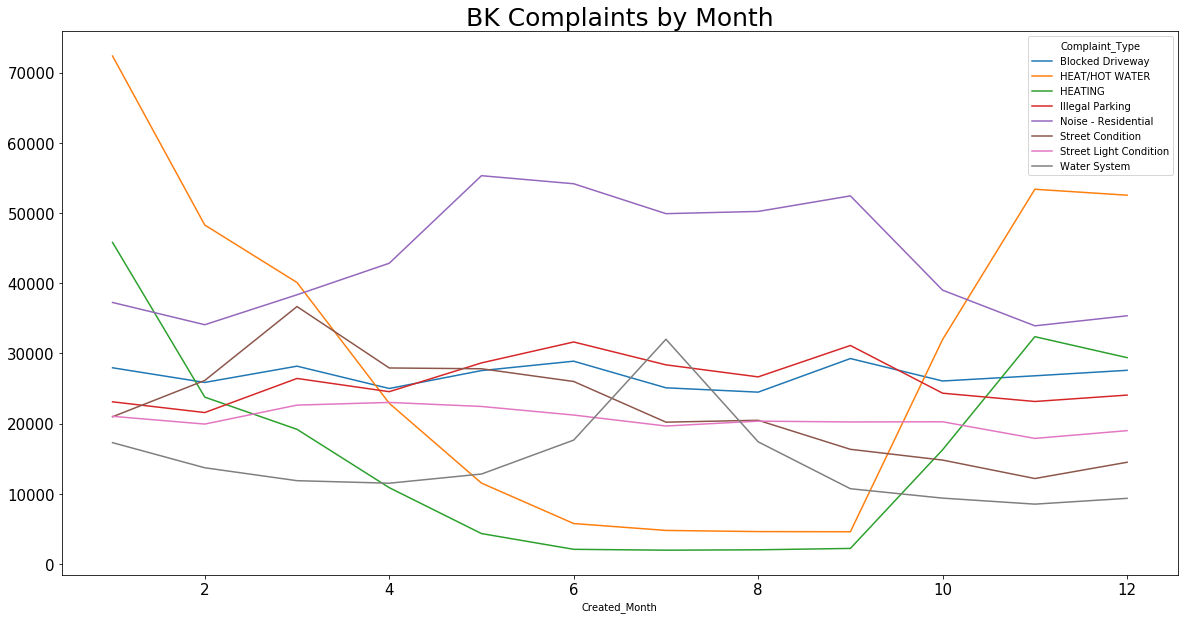

In [16]:

complaints_monthly_pdf_bk_pivot.plot(figsize=(20,10), fontsize=15).set_title('BK Complaints by Month', fontsize = 25)


In [17]:
complaints_monthly_queens = spark.sql("select Complaint_Type, Created_Month, count(*) as count \
from time_data_sql \
where Created_Month IS NOT NULL and Complaint_Type IS NOT NULL and Borough = 'QUEENS' \
group by Complaint_Type, Created_Month \
having Complaint_Type in ('Noise - Residential', 'HEAT/HOT WATER', 'HEATING','Street Condition','Street Light Condition',\
'Blocked Driveway','Water System','Illegal Parking')\
order by Created_Month")

complaints_monthly_queens_pdf = complaints_monthly_queens.toPandas()
complaints_monthly_pdf_queens_pivot = complaints_monthly_queens_pdf.pivot(index='Created_Month', columns='Complaint_Type', values='count')

Text(0.5,1,'Queens Complaints by Month')

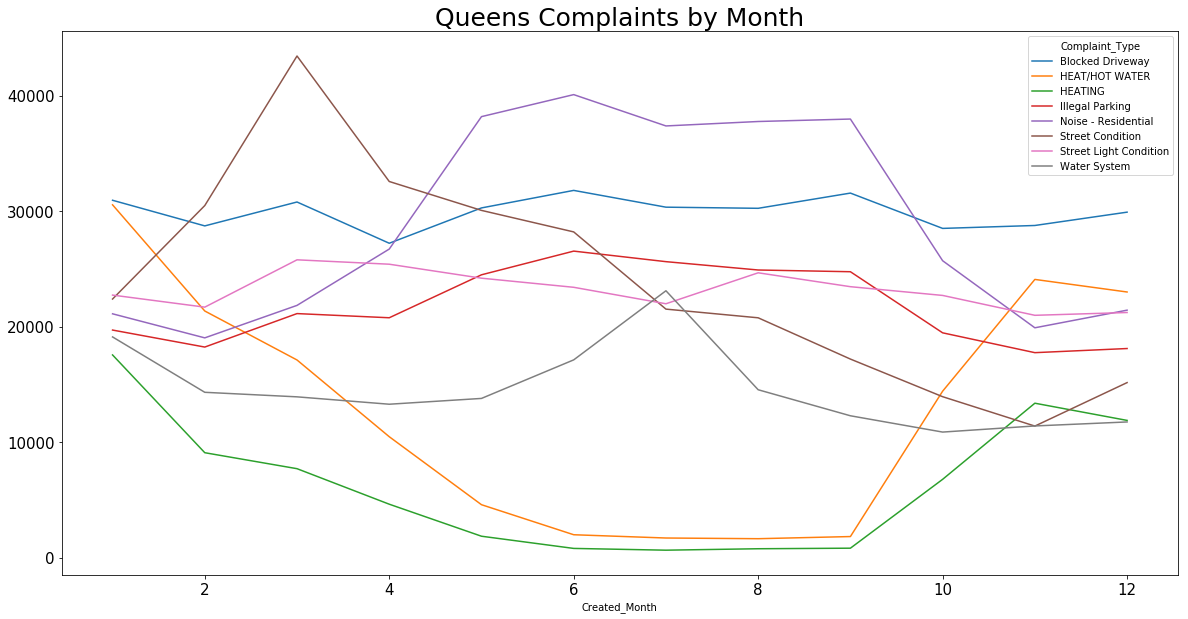

In [18]:
complaints_monthly_pdf_queens_pivot.plot(figsize=(20,10), fontsize=15).set_title('Queens Complaints by Month', fontsize = 25)